In [1]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("daily_data.pa")

df = data.sort('open_time').sort("symbol")

df = df.with_columns([
    pl.col('high').rolling_std(50).over('symbol').alias('high_rolling_std')
])

# 按日期和因子值排序并进行排名
df = df.with_columns([
    pl.col("high_rolling_std").rank("dense").over("open_time").alias("rank_high_rolling_std"),
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('return')
])

N = 150

# 计算相关系数的函数
def rolling_corr(a, b):
    return np.corrcoef(a, b)[0, 1]

# 使用 groupby 进行分组并计算滚动窗口的相关系数
def calculate_rolling_corr(group):
    high_series = group["high"].to_numpy()
    vol_series = group["volume"].to_numpy()

    rolling_correlations = []
    for i in range(N - 1, len(high_series)):
        high_window = high_series[i - N + 1:i + 1]
        vol_window = vol_series[i - N + 1:i + 1]
        correlation = rolling_corr(high_window, vol_window)
        rolling_correlations.append(correlation)

    return pl.DataFrame({
        "open_time": group["open_time"][N - 1:],
        "symbol": group["symbol"][N - 1:],
        "high_vol_correlation": rolling_correlations
    })

# 使用groupby进行分组并应用函数
result_df = df.group_by("symbol").map_groups(calculate_rolling_corr)

result_df


open_time,symbol,high_vol_correlation
datetime[μs],str,f64
2022-09-25 00:00:00,"""DARUSDT""",0.747893
2022-09-26 00:00:00,"""DARUSDT""",0.679208
2022-09-27 00:00:00,"""DARUSDT""",0.667152
2022-09-28 00:00:00,"""DARUSDT""",0.672561
2022-09-29 00:00:00,"""DARUSDT""",0.698278
…,…,…
2022-11-09 00:00:00,"""FTTUSDT""",-0.476867
2022-11-10 00:00:00,"""FTTUSDT""",-0.61322
2022-11-11 00:00:00,"""FTTUSDT""",-0.67176


In [2]:
df = df.join(result_df, on=["open_time", "symbol"], how="inner")

df = df.with_columns([
    (-1 * pl.col('rank_high_rolling_std') * pl.col('high_vol_correlation')).alias('Alpha040')
])

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,high_rolling_std,rank_high_rolling_std,return,high_vol_correlation,Alpha040
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,u32,f64,f64,f64
2023-10-02 00:00:00,0.01938,0.02093,0.01861,0.01899,2.3908e9,2023-10-02 23:59:59.999,4.7630e7,221725,1.1740e9,2.3408e7,"""1000FLOKIUSDT""",0.002135,35,-0.019618,0.212993,-7.454743
2023-10-03 00:00:00,0.01898,0.01924,0.01766,0.01772,7.91657458e8,2023-10-03 23:59:59.999,1.4502e7,83945,3.92386387e8,7.1910e6,"""1000FLOKIUSDT""",0.001911,35,-0.066877,0.209955,-7.348409
2023-10-04 00:00:00,0.01771,0.01787,0.0171,0.01768,5.09765058e8,2023-10-04 23:59:59.999,8.9421e6,60522,2.49116753e8,4.3711e6,"""1000FLOKIUSDT""",0.00162,34,-0.002257,0.19736,-6.710228
2023-10-05 00:00:00,0.01768,0.01912,0.01756,0.01811,2.9569e9,2023-10-05 23:59:59.999,5.4905e7,231939,1.4760e9,2.7419e7,"""1000FLOKIUSDT""",0.001437,34,0.024321,0.171993,-5.847753
2023-10-06 00:00:00,0.0181,0.01864,0.01805,0.01833,7.99557771e8,2023-10-06 23:59:59.999,1.4683e7,76911,3.84972002e8,7.0710e6,"""1000FLOKIUSDT""",0.00131,32,0.012148,0.168155,-5.380961
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-03-08 00:00:00,0.5161,0.5819,0.4875,0.5575,1.8804e8,2024-03-08 23:59:59.999,1.0033e8,686024,8.9756e7,4.7898e7,"""ZRXUSDT""",0.06359,101,0.080426,0.217061,-21.92315
2024-03-09 00:00:00,0.5576,0.6067,0.5397,0.5785,9.4661e7,2024-03-09 23:59:59.999,5.3586e7,380425,4.6599725e7,2.6364e7,"""ZRXUSDT""",0.071556,103,0.037668,0.216602,-22.309961
2024-03-10 00:00:00,0.5785,0.8259,0.5671,0.8005,7.80136805e8,2024-03-10 23:59:59.999,5.9270e8,2616066,3.9341e8,2.9910e8,"""ZRXUSDT""",0.095571,114,0.383751,0.261938,-29.860879


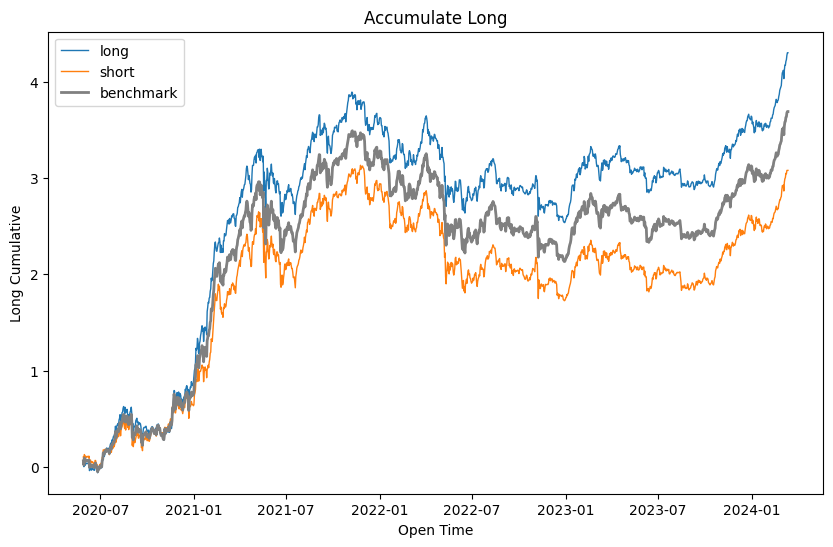

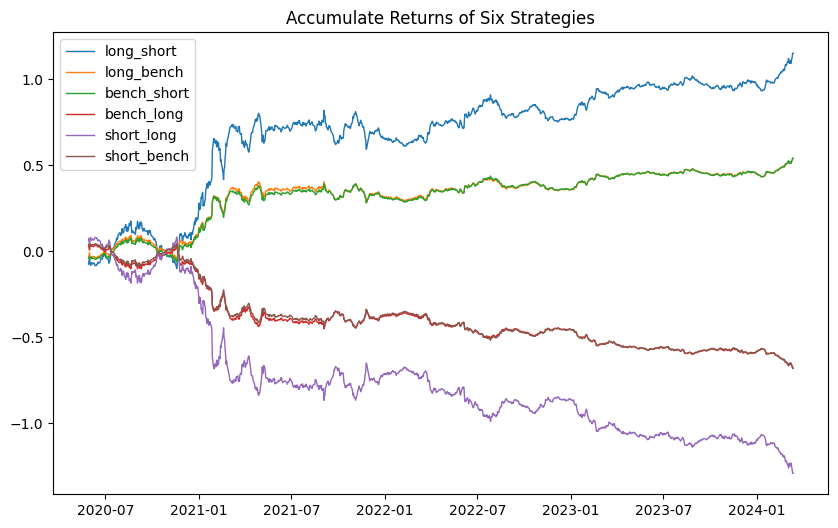

long: 
ann_return = 27.2166  sharpe = 6.1591  maxdd = 0.2768  calmar_ratio = 98.3181  

short: 
ann_return = 19.4874  sharpe = 4.4783  maxdd = 0.3402  calmar_ratio = 57.2902  

bench: 
ann_return = 23.3539  sharpe = 5.3807  maxdd = 0.3023  calmar_ratio = 77.2479  

long_short: 
ann_return = 7.2912  sharpe = 5.9086  maxdd = 0.2355  calmar_ratio = 30.9658  

long_bench: 
ann_return = 3.4247  sharpe = 5.4914  maxdd = 0.1285  calmar_ratio = 26.6575  

bench_long: 
ann_return = -4.3007  sharpe = -6.8961  maxdd = 0.6913  calmar_ratio = -6.2215  

short_long: 
ann_return = -8.1672  sharpe = -6.6185  maxdd = 1.268  calmar_ratio = -6.4411  

short_bench: 
ann_return = -4.3045  sharpe = -6.9814  maxdd = 0.6939  calmar_ratio = -6.2031  

bench_short: 
ann_return = 3.4285  sharpe = 5.5607  maxdd = 0.1307  calmar_ratio = 26.234  



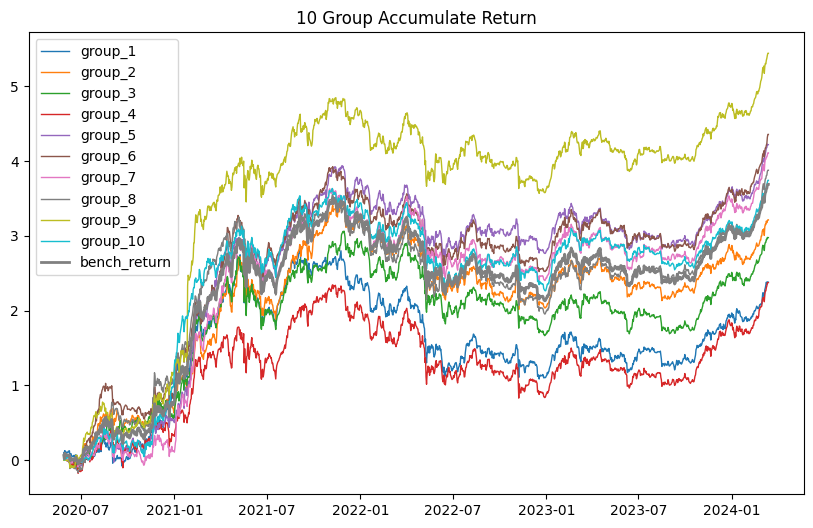

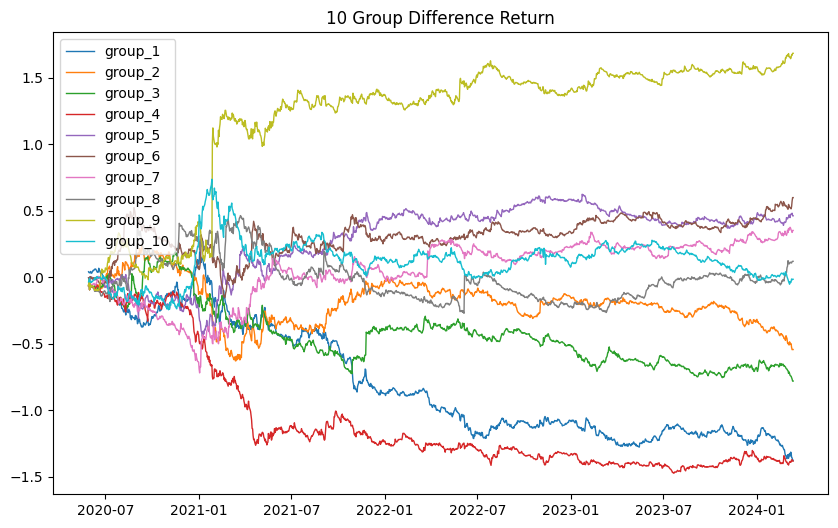

group_1: 
ann_return = 15.0725  sharpe = 3.3688  maxdd = 0.4552  calmar_ratio = 33.1141  

group_2: 
ann_return = 20.3473  sharpe = 4.3879  maxdd = 0.3247  calmar_ratio = 62.6734  

group_3: 
ann_return = 18.8438  sharpe = 4.1554  maxdd = 0.3439  calmar_ratio = 54.7899  

group_4: 
ann_return = 15.0365  sharpe = 3.3173  maxdd = 0.4527  calmar_ratio = 33.2147  

group_5: 
ann_return = 26.709  sharpe = 5.8642  maxdd = 0.3466  calmar_ratio = 77.0498  

group_6: 
ann_return = 27.5777  sharpe = 5.9354  maxdd = 0.2849  calmar_ratio = 96.7907  

group_7: 
ann_return = 26.014  sharpe = 5.4014  maxdd = 0.321  calmar_ratio = 81.0433  

group_8: 
ann_return = 24.5457  sharpe = 5.2391  maxdd = 0.3507  calmar_ratio = 69.9877  

group_9: 
ann_return = 34.4441  sharpe = 6.5346  maxdd = 0.3087  calmar_ratio = 111.5793  

group_10: 
ann_return = 23.6903  sharpe = 5.3634  maxdd = 0.2953  calmar_ratio = 80.2227  

-----------------------------------------
group_difference_1: 
ann_return = -8.7194  sharpe

In [3]:
factors = df.select(['open_time', 'symbol', 'Alpha040'])

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()